In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from urllib.request import urlopen
import requests
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

from scipy import stats
from sklearn.ensemble import RandomForestClassifier 

In [12]:
link = "https://raw.githubusercontent.com/shuailab/ind_498/master/resource/data/AD_hd.csv"
r = requests.get(link)
data = pd.read_csv(StringIO(r.text))
X = data.copy()
X = X.drop(['RID', 'DX_bl', 'MMSCORE'], axis = 1)
Y = data['MMSCORE']

### Lasso

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

.

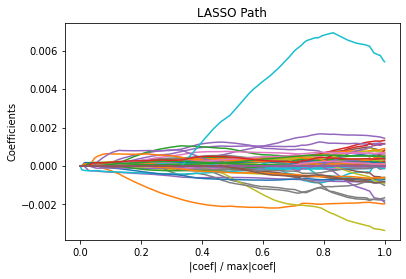

In [43]:
from sklearn.linear_model import lars_path
alphas, active, coefs, n_iter = linear_model.lars_path(x_train.values, y_train.values,
                                method='lasso', return_n_iter=True, verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

In [241]:
from sklearn.model_selection import GridSearchCV
clf_ = linear_model.Lasso()
alpha_v = np.arange(0.005,0.5,0.005)
clf = GridSearchCV(clf_,dict(alpha=alpha_v), cv=10, scoring='neg_mean_absolute_error' )
clf.fit(x_train.values, y_train.values)

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045,
       0.05 , 0.055, 0.06 , 0.065, 0....
       0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315,
       0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355, 0.36 ,
       0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  , 0.405,
       0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445, 0.45 ,
       0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 , 0.495])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', v

Text(0, 0.5, 'Mean-Squared Error')

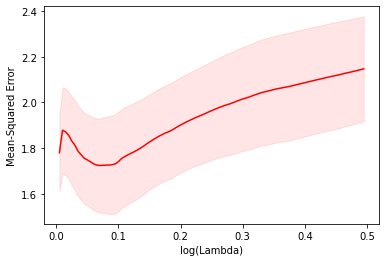

In [242]:
alpha_v = np.array( clf.cv_results_['param_alpha'], dtype=float)
mean_v = - np.array( clf.cv_results_['mean_test_score'], dtype=float )
upper_v = - np.array( clf.cv_results_['mean_test_score'], dtype=float ) + \
         np.array(clf.cv_results_['std_test_score']/np.sqrt(10), dtype=float)
lower_v = - np.array( clf.cv_results_['mean_test_score'], dtype=float ) - \
         np.array(clf.cv_results_['std_test_score']/np.sqrt(10), dtype=float)

fig, ax = plt.subplots()
ax.plot( #np.log(alpha_v), 
        alpha_v,
        mean_v,
        color='red')

ax.fill_between(# np.log(alpha_v),
                alpha_v,
                lower_v, 
                upper_v,color='r', alpha=.1)
ax.set_xlabel('log(Lambda)')
ax.set_ylabel('Mean-Squared Error')


In [243]:
print( clf.best_params_ )
print( clf.best_estimator_ )
clf.best_estimator_.fit(x_train.values, y_train.values)
y_pred = clf.best_estimator_.predict(x_test)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_pred, y_test)

{'alpha': 0.07}
Lasso(alpha=0.07, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


5.838763493519461

In [253]:
selected_feat = x_train.columns[(clf.best_estimator_.coef_ > 0)]
print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 326
selected features: 58


### PCA

In [286]:
# Generate data
data = pd.DataFrame( np.array([[-10, -4, 2, 8, 14],
                        [6, 2, 1, 0, -4]]).T,
             columns=['X1','X2']
            )

from sklearn import preprocessing
data_scaled = preprocessing.scale(data)
data_scaled = pd.DataFrame(data_scaled, columns=['X1','X2'])
data_corr = data_scaled.corr(method ='pearson')

In [280]:
print(data_scaled.mean(axis=0))
print(data_scaled.std(axis=0))

X1   -4.440892e-17
X2    0.000000e+00
dtype: float64
X1    1.118034
X2    1.118034
dtype: float64


In [292]:
data_corr
data_scaled

,X1,X2
0,-1.414214,1.550434
1,-0.707107,0.310087
2,0.000000,0.000000
3,0.707107,-0.310087
4,1.414214,-1.550434


Text(0, 0.5, 'X2')

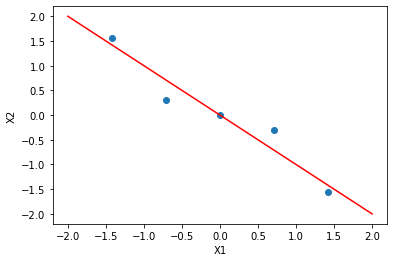

In [301]:
import scipy.linalg as la
results = la.eig(data_corr)

intercept = 0
slope = results[1][1,0] / results[1][0,0]
x = np.linspace(-2,2,100)
y = x*slope + intercept

plt.scatter(data_scaled.X1, data_scaled.X2, marker='o')
plt.plot(x, y, '-r', label='y=2x+1')
plt.xlabel('X1')
plt.ylabel('X2')

### Lab

In [337]:
link = "https://raw.githubusercontent.com/shuailab/ind_498/master/resource/data/AD_hd.csv"
r = requests.get(link)
data = pd.read_csv(StringIO(r.text))
# X = X.drop(['RID', 'DX_bl', 'MMSCORE'], axis = 1)
X = data.drop(data.columns[[np.arange(0,16)]], axis = 1) 
Y = data[['MMSCORE']]

print(data.shape)
print(X.shape)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

(73, 329)
(73, 313)


In [344]:
print(x_train.shape)

(58, 313)


In [377]:
x_colnames = x_train.columns

In [356]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scale = scaler.transform(x_train)
x_test_scale = scaler.transform(x_test)


In [354]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(x_train_scale)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [404]:
x_train_pca = pca.transform(x_train_scale)
x_test_pca = pca.transform(x_test_scale)

<BarContainer object of 10 artists>

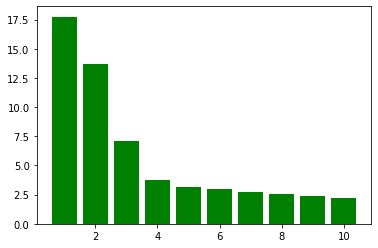

In [361]:
import matplotlib.pyplot as plt
plt.bar(np.arange(1,len(pca.explained_variance_ratio_)+1), 100 * pca.explained_variance_ratio_, color='green')


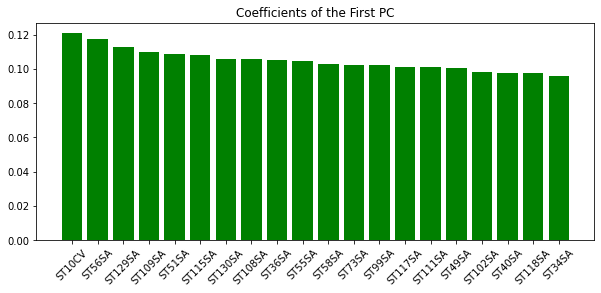

In [402]:
control_v = pca.components_[0,]
sorted_ix = np.argsort(-np.abs(control_v))[0:20]
fig, ax = plt.subplots(figsize = (10,4))
ax.bar(np.arange(1,len(sorted_ix)+1), control_v[sorted_ix]
        , color='green')
ax.set_xticks(np.arange(1,len(sorted_ix)+1))
ax.set_xticklabels(x_colnames[sorted_ix],rotation=45)
ax.set_title("Coefficients of the First PC")
plt.show()

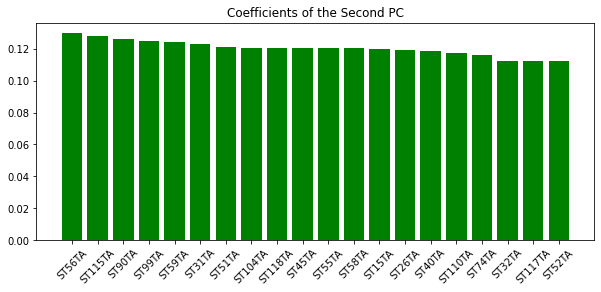

In [403]:
control_v = pca.components_[1,]
sorted_ix = np.argsort(-np.abs(control_v))[0:20]
fig, ax = plt.subplots(figsize = (10,4))
ax.bar(np.arange(1,len(sorted_ix)+1), np.abs(control_v[sorted_ix])
        , color='green')
ax.set_xticks(np.arange(1,len(sorted_ix)+1))
ax.set_xticklabels(x_colnames[sorted_ix],rotation=45)
ax.set_title("Coefficients of the Second PC")
plt.show()

In [ ]:
x_train_pca = pca.transform(x_train_scale)
x_test_pca = pca.transform(x_test_scale)

In [407]:
# linear model

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train_pca, y_train)
y_pred = reg.predict(x_test_pca)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_pred, y_test)

1.7817480257460125

In [415]:
import statsmodels.api as sm
mod = sm.OLS(y_train, sm.add_constant(x_train_pca) )
res = mod.fit()
y_pred = res.predict(sm.add_constant(x_test_pca))
from sklearn.metrics import mean_squared_error

print("mean squared error:", mean_squared_error(y_pred, y_test) )

print(res.summary())

mean squared error: 1.7817480257460083
                            OLS Regression Results                            
Dep. Variable:                MMSCORE   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     1.619
Date:                Sun, 31 May 2020   Prob (F-statistic):              0.131
Time:                        23:00:41   Log-Likelihood:                -99.502
No. Observations:                  58   AIC:                             221.0
Df Residuals:                      47   BIC:                             243.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

In [417]:
x_train_pca.shape

(58, 10)

In [423]:
x_train_pca[:, 1]

array([ 1.91050588e+00,  5.48527341e+00, -6.24443715e+00,  5.81836004e-01,
       -5.39680969e-01, -6.80607518e+00, -1.38470773e+00,  4.56115477e+00,
        7.48804781e+00,  8.37809383e+00,  4.64037797e+00, -8.88043055e-01,
        6.51799373e+00,  8.70052113e+00, -8.31566989e+00,  2.20574153e+00,
       -4.79474693e+00, -3.40021109e+00, -1.15787136e+00,  1.41730378e+01,
       -6.30963644e+00,  4.77723223e+00,  9.10990322e+00,  2.84205260e+00,
       -1.31162580e+01,  9.11610218e+00, -3.32589367e+00,  7.77084341e-01,
       -1.16658353e+00, -1.07812555e+01, -6.87462065e-01,  9.24061572e-01,
       -7.24916553e+00,  2.23573110e+00, -4.00747832e+00, -1.30131852e-02,
        5.23515659e+00,  1.74234267e+01, -6.15245200e+00,  7.03868494e+00,
        8.34337022e+00, -3.32038284e+00, -8.90189754e+00, -2.86277688e+00,
        9.51439429e+00, -8.42612118e+00, -1.27626562e+01, -7.54091127e+00,
       -8.25381606e-01,  6.75487725e+00, -3.89927622e+00,  2.80413902e+00,
       -3.44390180e+00, -